## High-Level Steps for the Adaptive Tensor SVD Background Subtraction Code

1.  **Import Libraries:** The code starts by importing necessary libraries for numerical operations (`numpy`), image processing (`cv2`, `skimage.metrics`), file handling (`os`, `glob`), Fourier analysis (`scipy.fft`), linear algebra (`numpy.linalg`), regular expressions (`re`), and plotting (`matplotlib.pyplot`, `time`).

2.  **`adaptive_tensor_svd_background()` Function (Main Execution):**
    * **Define Parameters:** Sets various parameters controlling the background subtraction process, such as the input image folder, file pattern, number of initial frames, thresholds, and batch sizes.
    * **Process with T-product:**
        * Calls `process_image_sequence()` with the 't' method to perform background subtraction using the T-product based tensor SVD.
        * Records the total computation time.
        * Calls `display_comparison()` to visualize the results (original, background, foreground) for the T-product method.
    * **Process with M-product:**
        * Calls `process_image_sequence()` with the 'm' method for background subtraction using the M-product based tensor SVD.
        * Records the total computation time.
        * Calls `display_comparison()` to visualize the results for the M-product method.
    * **Display Metrics:** Calls `display_metrics()` to compare quantitative metrics (like foreground similarity) between the T-product and M-product results.
    * **Plot Computation Time:** Generates a bar plot comparing the total computation time of the T-product and M-product methods.

3.  **`tsvd_comp(A, tau_star)` Function (T-product SVD Computation):**
    * Computes the T-product based Singular Value Decomposition (SVD) of an input tensor `A`.
    * Applies the Fourier Transform along the third dimension (temporal).
    * Performs standard SVD on each frontal slice in the frequency domain.
    * Determines the rank of the SVD based on a threshold (`tau_star`) applied to the differences in singular values.
    * Truncates the SVD components (U and Sigma) based on the determined rank.
    * Applies the Inverse Fourier Transform to get the spatial domain components.

4.  **`msvd_comp(A, M, tau_star)` Function (M-product SVD Computation):**
    * Computes the M-product based SVD of an input tensor `A`.
    * Applies the mode-3 product with the `M` matrix to transform the tensor.
    * Performs standard SVD on each frontal slice of the transformed tensor.
    * Determines the rank based on the thresholding of singular values.
    * Truncates the SVD components (Um and Sm).
    * Applies the inverse mode-3 product to transform the components back to the original domain.

5.  **`svdappend(U, S, V, B)` Function (Appending Data to SVD):**
    * Appends new data `B` to an existing SVD represented by `U`, `S`, and `V` using an efficient update method. This avoids recomputing the full SVD.

6.  **`tsvd_append(U, Sigma, T, tau_star)` Function (Appending Data to T-product SVD):**
    * Extends the `svdappend` logic to the frequency domain for T-product SVD.
    * Transforms the existing SVD components (`U`, `Sigma`) and the new data `T` to the frequency domain.
    * Uses `svdappend` on each frequency slice.
    * Determines a new rank based on the updated singular values.
    * Truncates the updated components and transforms them back to the spatial domain.

7.  **`msvd_append(U, Sigma, T, M, tau_star)` Function (Appending Data to M-product SVD):**
    * Extends the `svdappend` logic to the M-product domain.
    * Transforms the existing SVD components (`U`, `Sigma`) and the new data `T` to the M-product domain using the `M` matrix.
    * Uses `svdappend` on each slice in the M-product domain.
    * Determines a new rank based on the updated singular values.
    * Truncates the updated components and transforms them back to the original domain using the inverse of `M`.

8.  **`process_image_sequence(...)` Function (Main Image Processing Loop):**
    * Reads image files from the specified folder.
    * Initializes the background model by processing the first `init_frames` and computing the initial T-product or M-product SVD.
    * Iterates through the remaining frames:
        * Reads the current frame.
        * Projects the current frame onto the current background model (`T_projection` or `M_projection`).
        * Computes a foreground mask by comparing the current frame with the projected background.
        * Stores the original frame, background, foreground, and rank in a results list.
        * Appends the current frame data to a temporary block `T`.
        * If `T` reaches a certain size (`beta`), it updates the background model's SVD using `tsvd_append` or `msvd_append`.
        * Periodically reinitializes the SVD model if the rank exceeds a threshold (`n_star`).

9.  **`T_projection(U, B)` Function (T-product Projection):**
    * Projects a tensor `B` onto the subspace spanned by the columns of `U` using the T-product. This is done in the frequency domain.

10. **`M_projection(U, B, M)` Function (M-product Projection):**
    * Projects a tensor `B` onto the subspace spanned by the columns of `U` using the M-product. This is done in the M-product domain.

11. **`mode3prod(A, M)` Function (Mode-3 Product):**
    * Computes the mode-3 product of a tensor `A` with a matrix `M`.

12. **`TProd(U, Sigma)` Function (T-product of Two Tensors):**
    * Computes the T-product of two tensors `U` and `Sigma` in the frequency domain.

13. **`MProd(U, Sigma, M)` Function (M-product of Two Tensors):**
    * Computes the M-product of two tensors `U` and `Sigma` using the matrix `M`.

14. **`display_metrics(results_t, results_m)` Function (Metrics Comparison):**
    * Calculates and displays comparison metrics between the foreground masks obtained from the T-product and M-product methods (currently only Jaccard similarity).
    * Also prints the average ranks of the models.

15. **`jaccard_similarity(A, B)` Function:**
    * Computes the Jaccard similarity between two binary masks.

16. **`display_comparison(results, method_name)` Function (Visual Result Display):**
    * Visualizes the original frames, the estimated background, and the detected foreground for a sample of frames.
    * Displays the Structural Similarity Index (SSIM) and Peak Signal-to-Noise Ratio (PSNR) between the original and background frames as quality metrics.
    * Saves the visualizations to image files.

In essence, the code implements an adaptive background subtraction algorithm using tensor Singular Value Decomposition. It explores two variants: one based on the T-product and another on the M-product, allowing for comparison of their performance. The algorithm adapts to changes in the scene over time by incrementally updating the SVD model and periodically reinitializing it.

In [27]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from numpy.linalg import svd, inv
import re
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


# Function to run the background subtraction algorithm
import time
import matplotlib.pyplot as plt

def adaptive_tensor_svd_background():
    # Parameters
    image_folder = 'frames_folder'
    pattern = '*.jpg'
    init_frames = 100
    max_frames = 800
    tau_star = 0.1
    tau = 0.01
    theta = 0.1
    beta = 10
    n_star = 30
    
    # Lists to store computation times
    t_times = []
    m_times = []
    frame_numbers = []
    
    # Process images with both methods
    print('Starting background subtraction using T-product...')
    start_time = time.time()
    results_t = process_image_sequence(image_folder, pattern, init_frames, tau_star, tau,
                                      theta, beta, n_star, max_frames, 't')
    t_time = time.time() - start_time
    t_times.append(t_time)
    
    # Display results for T-product
    display_comparison(results_t, "T")
    
    print('Starting background subtraction using M-product...')
    start_time = time.time()
    results_m = process_image_sequence(image_folder, pattern, init_frames, tau_star, tau,
                                     theta, beta, n_star, max_frames, 'm')
    m_time = time.time() - start_time
    m_times.append(m_time)
    
    # Display results M-product
    display_comparison(results_m, "M")
    
    # Display metrics comparison
    display_metrics(results_t, results_m)
    
    # Plot computation time comparison
    # Data
    methods = ['T-product', 'M-product']
    times = [t_times[0], m_times[0]]

    # Create bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, times, color=['skyblue', 'lightgreen'])

    # Labeling
    plt.ylabel('Computation Time (seconds)')
    plt.title('Computation Time Comparison between T-product and M-product')

    # Annotate each bar
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{time_val:.2f}s', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Compute T-product SVD
def tsvd_comp(A, tau_star):
    
    # Get dimensions
    m, n, p = A.shape
    
    # Compute FFT along 3rd dimension
    Af = fft(A, axis=2)
    
    # Preallocate
    Uf = np.zeros((m, min(m, n), p), dtype=complex)
    Sf = np.zeros((min(m, n), min(m, n), p), dtype=complex)
    
    # Compute SVD for each frontal slice
    for j in range(p):
        U_temp, s_temp, _ = svd(Af[:,:,j], full_matrices=False)
        Uf[:,:,j] = U_temp
        
        # Store diagonal singular values
        Sf[:,:,j] = np.diag(s_temp)
    
    # Calculate average singular values across all slices
    s_values = np.zeros(min(m, n))
    for j in range(p):
        s_values += np.abs(np.diag(Sf[:,:,j]))
    s_values /= p
    
    # Calculate differences between consecutive singular values
    diffs = np.diff(s_values)
    
    # Apply threshold based on the slope of singular values
    # Use tau_star as a fraction of the singular values
    threshold = tau_star * s_values[:-1]
    # Find indices where diff is below threshold
    idx = np.where(diffs < threshold)[0]
    
    if len(idx) == 0:
        # Use all singular values if none below threshold
        i = len(s_values)
    else:
        i = idx[0] + 1
    
    # Truncate SVD components
    Uf_truncated = np.zeros((m, i, p), dtype=complex)
    Sf_truncated = np.zeros((i, i, p), dtype=complex)
    
    for j in range(p):
        Uf_truncated[:,:,j] = Uf[:,:i,j]
        Sf_truncated[:,:,j] = Sf[:i,:i,j]
    
    # Transform back to spatial domain
    U = np.real(ifft(Uf_truncated, axis=2))
    Sigma = np.real(ifft(Sf_truncated, axis=2))
    
    return U, Sigma, i

# Compute M-product SVD
def msvd_comp(A, M, tau_star):
    
    # Get dimensions
    m, n, p = A.shape
    
    # Apply mode-3 product
    D = mode3prod(A, M)
    
    # Preallocate
    Um = np.zeros((m, min(m, n), p))
    Sm = np.zeros((min(m, n), min(m, n), p))
    
    # Perform SVD for each slice
    for j in range(p):
        U_temp, s_temp, _ = svd(D[:,:,j], full_matrices=False)
        Um[:,:,j] = U_temp
        
        # Store diagonal singular values
        Sm[:,:,j] = np.diag(s_temp)
    
    # Calculate average singular values across all slices
    s_values = np.zeros(min(m, n))
    for j in range(p):
        s_values += np.abs(np.diag(Sm[:,:,j]))
    s_values /= p
    
    # Calculate differences between consecutive singular values
    diffs = np.diff(s_values)
    
    # Apply threshold based on the slope of singular values
    # Use tau_star as a fraction of the singular values
    threshold = tau_star * s_values[:-1]
    # Find indices where diff is below threshold
    idx = np.where(diffs < threshold)[0]
    
    if len(idx) == 0:
        # Use all singular values if none below threshold
        i = len(s_values)
    else:
        i = idx[0] + 1
    
    # Truncate SVD components
    Um_truncated = np.zeros((m, i, p))
    Sm_truncated = np.zeros((i, i, p))
    
    for j in range(p):
        Um_truncated[:,:,j] = Um[:,:i,j]
        Sm_truncated[:,:,j] = Sm[:i,:i,j]
    
    # Transform back using inverse mode-3 product
    U = mode3prod(Um_truncated, inv(M))
    Sigma = mode3prod(Sm_truncated, inv(M))
    
    return U, Sigma, i

# Append new data to an existing SVD
def svdappend(U, S, V, B):
    m, k = U.shape
    l = B.shape[1]
    
    # Orthogonalize B against U
    UB = U.T @ B
    B_perp = B - U @ UB
    
    # QR factorization of B_perp
    Q, R = np.linalg.qr(B_perp, mode='reduced')
    
    # Construct K matrix
    K = np.block([
        [S, UB],
        [np.zeros((l, k)), R]
    ])
    
    # SVD of K
    Uk, Sk, Vk = svd(K, full_matrices=False)
    
    # Update U and S
    U_new = np.hstack((U, Q)) @ Uk
    S_new = np.diag(Sk)
    
    return U_new, S_new, None

# Update T-product SVD with new data using svdappend in frequency domain
def tsvd_append(U, Sigma, T, tau_star):
    
    # Get dimensions
    m, r, p = U.shape
    _, n_frames, _ = T.shape
    
    # Convert to Fourier domain
    U_fft = fft(U, axis=2)
    Sigma_fft = fft(Sigma, axis=2)
    T_fft = fft(T, axis=2)
    
    # Identity V matrices for svdappend (since we don't track V)
    V_fft = np.zeros((r, r, p), dtype=complex)
    for j in range(p):
        V_fft[:,:,j] = np.eye(r)
    
    # Updated components in frequency domain
    U_new_fft = np.zeros((m, r + n_frames, p), dtype=complex)
    S_new_fft = np.zeros((r + n_frames, r + n_frames, p), dtype=complex)
    
    # Apply svdappend to each frequency slice
    for j in range(p):
        U_temp, S_temp, _ = svdappend(U_fft[:,:,j], Sigma_fft[:,:,j], V_fft[:,:,j], T_fft[:,:,j])
        
        # Store the results
        U_new_fft[:,:,j] = U_temp
        
        # Handle case where S_temp might be a vector
        if S_temp.ndim == 1:
            S_new_fft[:,:,j] = np.diag(S_temp)
        else:
            S_new_fft[:,:,j] = S_temp
    
    # Calculate average singular values across all slices
    s_values = np.zeros(min(r + n_frames, m))
    for j in range(p):
        s_values += np.abs(np.diag(S_new_fft[:,:,j]))
    s_values /= p
    
    # Calculate differences between consecutive singular values
    diffs = np.diff(s_values)
    
    # Apply threshold based on the slope of singular values
    # Use tau_star as a fraction of the singular values
    threshold = tau_star * s_values[:-1]
    # Find indices where diff is below threshold
    idx = np.where(diffs < threshold)[0]
    
    if len(idx) == 0:
        # Use all singular values if none below threshold
        i_new = len(s_values)
    else:
        i_new = idx[0] + 1
    
    # Truncate to the new rank
    U_new_fft_truncated = np.zeros((m, i_new, p), dtype=complex)
    S_new_fft_truncated = np.zeros((i_new, i_new, p), dtype=complex)
    
    for j in range(p):
        U_new_fft_truncated[:,:,j] = U_new_fft[:,:i_new,j]
        S_new_fft_truncated[:,:,j] = S_new_fft[:i_new,:i_new,j]
    
    # Convert back to spatial domain
    U_new = np.real(ifft(U_new_fft_truncated, axis=2))
    Sigma_new = np.real(ifft(S_new_fft_truncated, axis=2))
    
    return U_new, Sigma_new, i_new

# Update M-product SVD with new data using svdappend in M-product domain
def msvd_append(U, Sigma, T, M, tau_star):
    
    # Get dimensions
    m, r, p = U.shape
    _, n_frames, _ = T.shape
    
    # Transform to M-product domain
    Um = mode3prod(U, M)
    Sigmam = mode3prod(Sigma, M)
    Tm = mode3prod(T, M)
    
    # Identity V matrices for svdappend (since we don't track V)
    Vm = np.zeros((r, r, p))
    for j in range(p):
        Vm[:,:,j] = np.eye(r)
    
    # Updated components in M-product domain
    Um_new = np.zeros((m, r + n_frames, p))
    Sm_new = np.zeros((r + n_frames, r + n_frames, p))
    
    # Apply svdappend to each slice
    for j in range(p):
        U_temp, S_temp, _ = svdappend(Um[:,:,j], Sigmam[:,:,j], Vm[:,:,j], Tm[:,:,j])
        
        # Store the results
        Um_new[:,:,j] = U_temp
        
        # Handle case where S_temp might be a vector
        if S_temp.ndim == 1:
            Sm_new[:,:,j] = np.diag(S_temp)
        else:
            Sm_new[:,:,j] = S_temp
    
    # Calculate average singular values across all slices
    s_values = np.zeros(min(r + n_frames, m))
    for j in range(p):
        s_values += np.abs(np.diag(Sm_new[:,:,j]))
    s_values /= p
    
    # Calculate differences between consecutive singular values
    diffs = np.diff(s_values)
    
    # Apply threshold based on the slope of singular values
    # Use tau_star as a fraction of the singular values
    threshold = tau_star * s_values[:-1]
    # Find indices where diff is below threshold
    idx = np.where(diffs < threshold)[0]
    
    if len(idx) == 0:
        # Use all singular values if none below threshold
        i_new = len(s_values)
    else:
        i_new = idx[0] + 1
    
    # Truncate to the new rank
    Um_new_truncated = np.zeros((m, i_new, p))
    Sm_new_truncated = np.zeros((i_new, i_new, p))
    
    for j in range(p):
        Um_new_truncated[:,:,j] = Um_new[:,:i_new,j]
        Sm_new_truncated[:,:,j] = Sm_new[:i_new,:i_new,j]
    
    # Convert back to original domain
    U_new = mode3prod(Um_new_truncated, inv(M))
    Sigma_new = mode3prod(Sm_new_truncated, inv(M))
    
    return U_new, Sigma_new, i_new

# Process a sequence of color images for background subtraction
def process_image_sequence(image_folder, pattern, init_frames, tau_star, tau, theta, beta, n_star, max_frames, method):
    
    # Get list of image files in the folder
    files = sorted(glob(os.path.join(image_folder, pattern)))
    
    if not files:
        raise ValueError(f'No images found in {image_folder} with pattern {pattern}')
    
    print(f'Found {len(files)} images')
    
    # Adjust init_frames if needed
    init_frames = min(init_frames, len(files))
    
    # Read first image to get dimensions
    first_img = cv2.imread(files[0])
    if first_img is None:
        raise ValueError(f'Could not read image {files[0]}')
    
    # Convert BGR to RGB for display
    first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)
    
    height, width, channels = first_img.shape
    
    # For grayscale images, set channels to 1
    if len(first_img.shape) == 2:
        channels = 1
    
    # Create M matrix for M-product (if using M-product)
    if method == 'm':
        M = np.diag(np.random.randint(1, 4, size=channels)) + np.eye(channels)
    
    # Initialize tensor A for initialization frames
    print(f'Reading {init_frames} initialization frames...')
    A = np.zeros((height * width, init_frames, channels))
    
    for i in range(init_frames):
        img = cv2.imread(files[i])
        if img is None:
            print(f'Could not read image {files[i]}')
            continue
        
        # Convert BGR to RGB for display
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Ensure color images have the correct number of channels
        if img.shape[2] != channels:
            if channels == 1:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                raise ValueError('Inconsistent number of channels in images')
        
        # Ensure all images have the same dimensions
        if img.shape[0] != height or img.shape[1] != width:
            img = cv2.resize(img, (width, height))
        
        # Normalize pixel values to [0,1]
        normalized = img.astype(np.float32) / 255.0
        
        # Reshape for each color channel and store
        for c in range(channels):
            if channels == 1:
                A[:, i, c] = normalized.flatten()
            else:
                A[:, i, c] = normalized[:,:,c].flatten()
    
    # Compute initial SVD components
    print('Computing initial SVD components...')
    if method == 't':
        U, Sigma, i = tsvd_comp(A, tau_star)
    else:
        U, Sigma, i = msvd_comp(A, M, tau_star)
    print(f'Initial SVD has {i} components')
    
    # Initialize tensor T for batch processing
    T = np.zeros((height * width, 0, channels))
    
    # Determine the number of frames to process
    total_frames = len(files)
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    # Create list to store results for all frames
    results = []
    
    # Process all frames
    print('Processing image frames...')
    
    for frame_count in range(total_frames):
        if frame_count % 10 == 0:
            print(f'Processing frame {frame_count}/{total_frames}')
        
        # Read frame
        try:
            img = cv2.imread(files[frame_count])
            if img is None:
                print(f'Could not read image {files[frame_count]}')
                continue
            
            # Convert BGR to RGB for display
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Ensure color images have the correct number of channels
            if img.shape[2] != channels:
                if channels == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                else:
                    raise ValueError('Inconsistent number of channels in images')
        except Exception as e:
            print(f'Error reading image {files[frame_count]}: {e}')
            continue
        
        # Ensure correct dimensions
        if img.shape[0] != height or img.shape[1] != width:
            img = cv2.resize(img, (width, height))
        
        # Normalize
        B = img.astype(np.float32) / 255.0
        B_tensor = np.zeros((height * width, 1, channels))
        
        # Reshape for each color channel
        for c in range(channels):
            if channels == 1:
                B_tensor[:,0,c] = B.flatten()
            else:
                B_tensor[:,0,c] = B[:,:,c].flatten()
        
        # Project B onto current background model
        if method == 't':
            # T-product projection
            J = T_projection(U, B_tensor)
        else:
            # M-product projection
            J = M_projection(U, B_tensor, M)
        
        # Compute foreground mask (combine from all channels)
        F = np.zeros((height * width, 1))
        for c in range(channels):
            diff = np.abs(B_tensor[:,0,c] - J[:,0,c])
            F = np.maximum(F, (diff > theta).reshape(-1, 1))
        F_reshaped = F.reshape(height, width)
        
        # Reshape background to image
        if channels == 1:
            background = J.reshape(height, width)
        else:
            background = np.zeros((height, width, channels))
            for c in range(channels):
                background[:,:,c] = J[:,0,c].reshape(height, width)
        
        # Store frame data in dictionary
        frame_result = {
            'original': B,
            'background': background,
            'foreground': F_reshaped,
            'rank': U.shape[1]
        }
        results.append(frame_result)
        
        # Append to block T
        T = np.concatenate((T, B_tensor), axis=1)
        
        # If block is full, update SVD
        if T.shape[1] == beta:
            if method == 't':
                U, Sigma, i = tsvd_append(U, Sigma, T, tau)
            else:
                U, Sigma, i = msvd_append(U, Sigma, T, M, tau)
            T = np.zeros((height * width, 0, channels))
            print(f'Updated SVD model at frame {frame_count}, new rank: {i}')
        
        # Check if we need reinitialization
        if U.shape[1] > n_star:
            print(f'Reinitializing SVD at frame {frame_count}...')
            # Create new tensor from U*Sigma
            if method == 't':
                A_new = TProd(U, Sigma)
                U, Sigma, i = tsvd_comp(A_new, tau_star)
            else:
                A_new = MProd(U, Sigma, M)
                U, Sigma, i = msvd_comp(A_new, M, tau_star)
            print(f'Reinitialized rank: {i}')
    
    print(f'Processing complete. Processed {total_frames} frames.')
    return results

# Project tensor B onto the subspace defined by U using T-product
def T_projection(U, B):
    m, r, p = U.shape
    J = np.zeros_like(B)
    
    # Convert to Fourier domain
    U_fft = fft(U, axis=2)
    B_fft = fft(B, axis=2)
    J_fft = np.zeros_like(B_fft)
    
    for i in range(p):
        # Project in Fourier domain
        J_fft[:,:,i] = U_fft[:,:,i] @ (U_fft[:,:,i].conj().T @ B_fft[:,:,i])
    
    # Convert back to spatial domain
    J = np.real(ifft(J_fft, axis=2))
    return J

# Project tensor B onto the subspace defined by U using M-product
def M_projection(U, B, M):
    m, r, p = U.shape
    
    # Convert to M-product domain
    UM = mode3prod(U, M)
    BM = mode3prod(B, M)
    JM = np.zeros_like(BM)
    
    for i in range(p):
        # Project in M-product domain
        JM[:,:,i] = UM[:,:,i] @ (UM[:,:,i].T @ BM[:,:,i])
    
    # Convert back to spatial domain
    J = mode3prod(JM, inv(M))
    return J

# Mode-3 product of a tensor A with matrix M"
def mode3prod(A, M):
    m, n, p = A.shape
    q = M.shape[0]
    
    # Reshape A to perform matrix multiplication
    A_mat = A.reshape(m*n, p)
    
    # Perform matrix multiplication
    C_mat = A_mat @ M.T
    
    # Reshape result back to tensor
    C = C_mat.reshape(m, n, q)
    
    return C

# T-product of tensors U and Sigma
def TProd(U, Sigma):

    m, r, p = U.shape
    
    # Convert to Fourier domain
    U_fft = fft(U, axis=2)
    Sigma_fft = fft(Sigma, axis=2)
    
    # Initialize result
    A_fft = np.zeros((m, r, p), dtype=complex)
    
    # Compute product in Fourier domain
    for i in range(p):
        A_fft[:,:,i] = U_fft[:,:,i] @ Sigma_fft[:,:,i]
    
    # Convert back to spatial domain
    A = np.real(ifft(A_fft, axis=2))
    
    return A

# M-product of tensors U and Sigma with matrix M
def MProd(U, Sigma, M):
    # Convert to M-product domain
    UM = mode3prod(U, M)
    SigmaM = mode3prod(Sigma, M)
    
    # Initialize result
    AM = np.zeros_like(UM)
    
    # Compute product in M-product domain
    for i in range(UM.shape[2]):
        AM[:,:,i] = UM[:,:,i] @ SigmaM[:,:,i]
    
    # Convert back to spatial domain
    A = mode3prod(AM, inv(M))
    
    return A

# Compare metrics between T-product and M-product methods
def display_metrics(results_t, results_m):
    
    # Get number of frames
    n_frames = min(len(results_t), len(results_m))
    
    # For large numbers of frames, select a sample
    if n_frames > 20:
        print(f'Too many frames ({n_frames}) to display all. Selecting metrics for a sample...')
        selected_indices = np.round(np.linspace(0, n_frames-1, 20)).astype(int)
        results_t = [results_t[i] for i in selected_indices]
        results_m = [results_m[i] for i in selected_indices]
        n_frames = 20
    
    # Get ranks for both methods
    t_ranks = [result['rank'] for result in results_t]
    m_ranks = [result['rank'] for result in results_m]
    
    # Create metrics comparison figure
    plt.figure(figsize=(12, 9), dpi=100, num='Method Comparison Metrics')
    
    # Compute similarity between foregrounds
    foreground_sim = []
    for i in range(n_frames):
        sim = jaccard_similarity(results_t[i]['foreground'], results_m[i]['foreground'])
        foreground_sim.append(sim)
    
    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(foreground_sim)+1), foreground_sim, 'k.-', linewidth=2)
    plt.xlabel('Frame')
    plt.ylabel('Jaccard Similarity')
    plt.title('Foreground Similarity Between Methods')
    plt.ylim([0, 1])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display average metrics
    avg_t_rank = np.mean(t_ranks)
    avg_m_rank = np.mean(m_ranks)
    avg_sim = np.mean(foreground_sim)
    
    print('\nComparison Metrics:')
    print(f'Average T-product model rank: {avg_t_rank:.2f}')
    print(f'Average M-product model rank: {avg_m_rank:.2f}')
    print(f'Average foreground similarity: {avg_sim:.4f}')

#Compute Jaccard similarity between two binary masks
def jaccard_similarity(A, B):
    
    A_bool = A.astype(bool)
    B_bool = B.astype(bool)
    
    intersection = np.sum(np.logical_and(A_bool, B_bool))
    union = np.sum(np.logical_or(A_bool, B_bool))
    
    if union == 0:
        sim = 1.0
    else:
        sim = intersection / union
    
    return sim


def display_comparison(results, method_name):
    # Get number of frames
    n_frames = len(results)
    original_indices = np.arange(n_frames)
    
    # For large numbers of frames, select a sample
    if n_frames > 20:
        print(f'Too many frames ({n_frames}) to display all. Selecting a sample...')
        selected_indices = np.round(np.linspace(0, n_frames-1, 20)).astype(int)
        # Store the actual frame numbers
        original_indices = selected_indices
        results = [results[i] for i in selected_indices]
        n_frames = len(results)
    
    # Determine figure prefix based on method name
    if method_name == 'T':
        fig_prefix = 'Tprod'
    else:
        fig_prefix = 'Mprod'
    
    # Calculate reasonable figure height
    figure_height = min(900, 200*n_frames)
    
    # Calculate the number of pages needed
    subplot_rows = min(n_frames, 5)  # Limit visible rows to 5
    num_pages = int(np.ceil(n_frames / subplot_rows))
    
    for page in range(1, num_pages+1):
        # Create figure for visual results
        plt.figure(figsize=(12, figure_height/75), dpi=75, 
                   num=f'{method_name}-product Background Subtraction')
        
        # Calculate range of frames to display on this page
        start_idx = (page-1)*subplot_rows
        end_idx = min(page*subplot_rows, n_frames)
        page_frames = end_idx - start_idx
        
        for i in range(page_frames):
            # Local index in our results array
            idx = start_idx + i
            # Actual frame number
            frame_num = original_indices[idx]
            
            # Get current result
            result = results[idx]
            original = result['original']
            background = result['background']
            
            # Calculate metrics with appropriate window size
            min_dim = min(original.shape[:2])
            win_size = min(7, min_dim)  # Ensure window size is odd and <= smallest dimension
            if win_size % 2 == 0:  # Make sure it's odd
                win_size -= 1
            
            try:
                if len(original.shape) == 2:  # Grayscale
                    ssim_val = ssim(original, background, 
                                   data_range=1.0,
                                   win_size=win_size)
                    psnr_val = psnr(original, background, 
                                   data_range=1.0)
                else:  # Color
                    ssim_val = ssim(original, background, 
                                   data_range=1.0,
                                   win_size=win_size,
                                   channel_axis=2)
                    psnr_val = psnr(original, background, 
                                   data_range=1.0)
            except Exception as e:
                print(f"Error calculating metrics for frame {frame_num}: {str(e)}")
                ssim_val = 0
                psnr_val = 0
            
            # Original
            plt.subplot(page_frames, 3, i*3 + 1)
            plt.imshow(original)
            plt.title(f'Frame {frame_num}: Original')
            plt.axis('off')
            
            # Background with metrics
            plt.subplot(page_frames, 3, i*3 + 2)
            plt.imshow(background)
            plt.title(f'Background\nSSIM: {ssim_val:.3f}\nPSNR: {psnr_val:.2f} dB')
            plt.axis('off')
            
            # Foreground
            plt.subplot(page_frames, 3, i*3 + 3)
            plt.imshow(result['foreground'], cmap='gray')
            plt.title('Foreground')
            plt.axis('off')
        
        plt.suptitle(f'{method_name}-product Background Subtraction (Page {page}/{num_pages})')
        plt.tight_layout()
        
        # Save the figure for this page
        fig_filename = f'{fig_prefix}{page}.png'
        print(f'Saving figure to {fig_filename}')
        plt.savefig(fig_filename)
        plt.show()

Starting background subtraction using T-product...
Found 800 images
Reading 100 initialization frames...
Computing initial SVD components...
Initial SVD has 1 components
Processing image frames...
Processing frame 0/800
Updated SVD model at frame 9, new rank: 1
Processing frame 10/800
Updated SVD model at frame 19, new rank: 1
Processing frame 20/800
Updated SVD model at frame 29, new rank: 1
Processing frame 30/800
Updated SVD model at frame 39, new rank: 1
Processing frame 40/800
Updated SVD model at frame 49, new rank: 1
Processing frame 50/800
Updated SVD model at frame 59, new rank: 1
Processing frame 60/800
Updated SVD model at frame 69, new rank: 1
Processing frame 70/800
Updated SVD model at frame 79, new rank: 1
Processing frame 80/800
Updated SVD model at frame 89, new rank: 1
Processing frame 90/800
Updated SVD model at frame 99, new rank: 1
Processing frame 100/800
Updated SVD model at frame 109, new rank: 1
Processing frame 110/800
Updated SVD model at frame 119, new rank:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0040611802769223715..1.0086142881975395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0023420256990517724..1.0007305368981965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004257219676284563..0.9957420023315314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00495902878477857..0.9993517739738348].


Updated SVD model at frame 799, new rank: 1
Processing complete. Processed 800 frames.
Too many frames (800) to display all. Selecting a sample...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007620217968597298..1.0278695307032881].


Saving figure to Tprod1.png


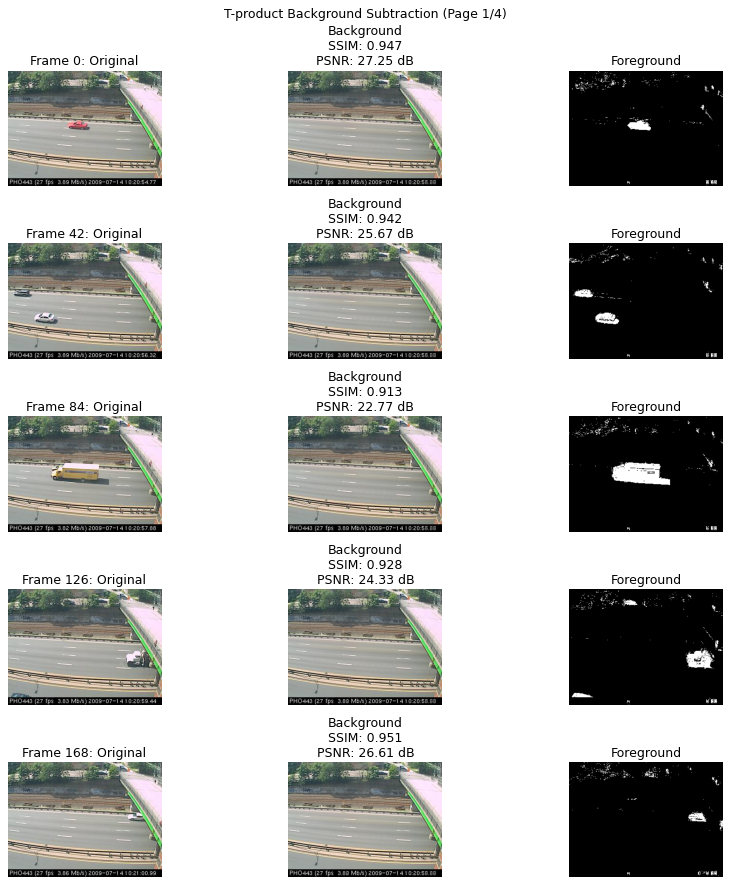

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021091501126409375..1.0238605811926582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031184044707314357..1.0566210502722915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04204608209848493..1.0959872572491656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05590168550247158..1.135279589925801].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07888030604070095..1.168112654768147].


Saving figure to Tprod2.png


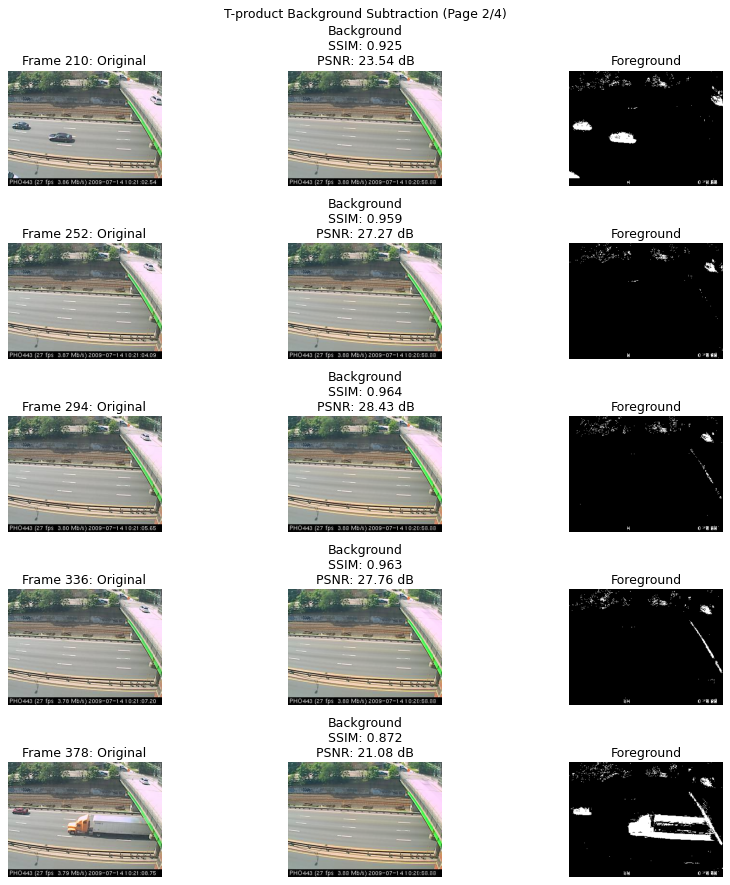

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09437427328430281..1.2369936162626556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11227492226364941..1.2789512310180118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12899206140366787..1.3242766628341058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14147431740529676..1.3732962304740284].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.159766389355563..1.3756410033186857].


Saving figure to Tprod3.png


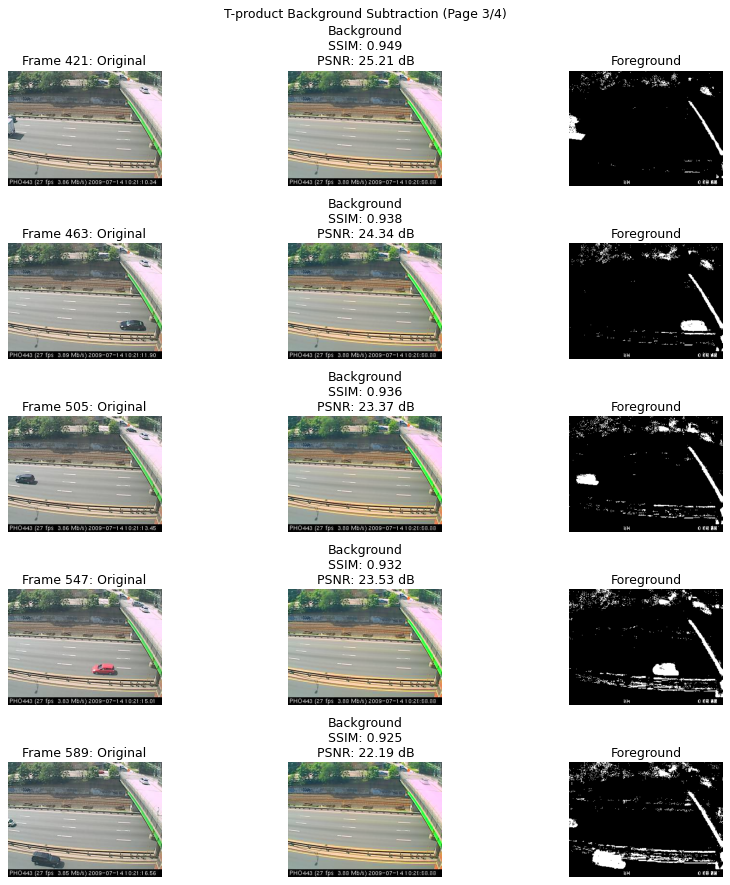

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21003035986462987..1.4225004996648831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20526042420672722..1.43480392563406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2410132995849512..1.4622873432307046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2676046468171115..1.5365639768972432].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2765578284638231..1.5997476716010732].


Saving figure to Tprod4.png


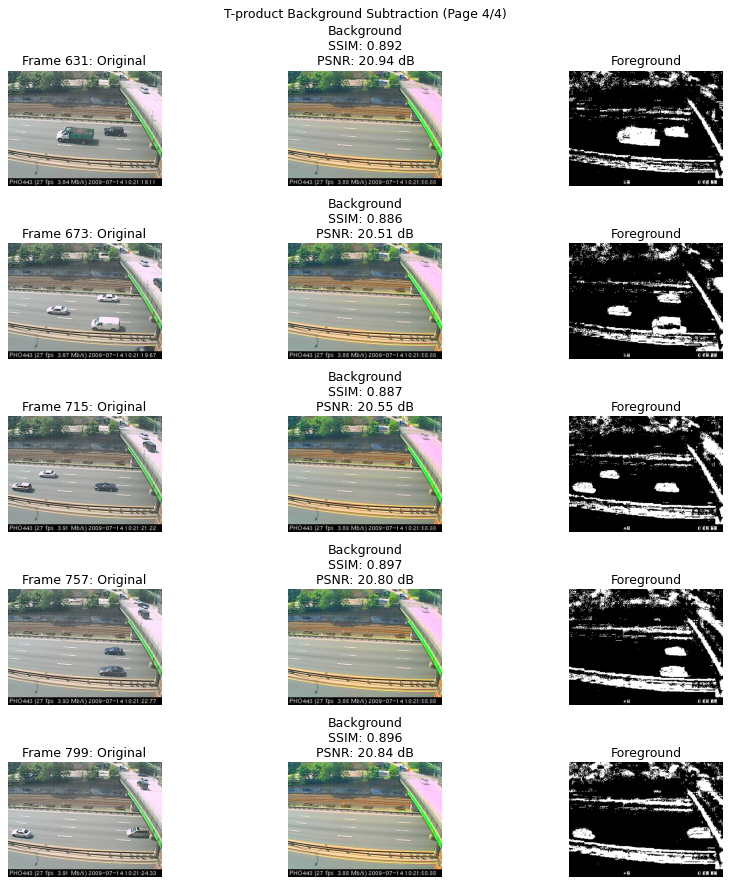

Starting background subtraction using M-product...
Found 800 images
Reading 100 initialization frames...
Computing initial SVD components...
Initial SVD has 1 components
Processing image frames...
Processing frame 0/800
Updated SVD model at frame 9, new rank: 1
Processing frame 10/800
Updated SVD model at frame 19, new rank: 1
Processing frame 20/800
Updated SVD model at frame 29, new rank: 1
Processing frame 30/800
Updated SVD model at frame 39, new rank: 1
Processing frame 40/800
Updated SVD model at frame 49, new rank: 1
Processing frame 50/800
Updated SVD model at frame 59, new rank: 1
Processing frame 60/800
Updated SVD model at frame 69, new rank: 1
Processing frame 70/800
Updated SVD model at frame 79, new rank: 1
Processing frame 80/800
Updated SVD model at frame 89, new rank: 1
Processing frame 90/800
Updated SVD model at frame 99, new rank: 1
Processing frame 100/800
Updated SVD model at frame 109, new rank: 1
Processing frame 110/800
Updated SVD model at frame 119, new rank:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0082594360540644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.002687348504959].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000356432808009].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0232214580694636].


Updated SVD model at frame 799, new rank: 1
Processing complete. Processed 800 frames.
Too many frames (800) to display all. Selecting a sample...
Saving figure to Mprod1.png


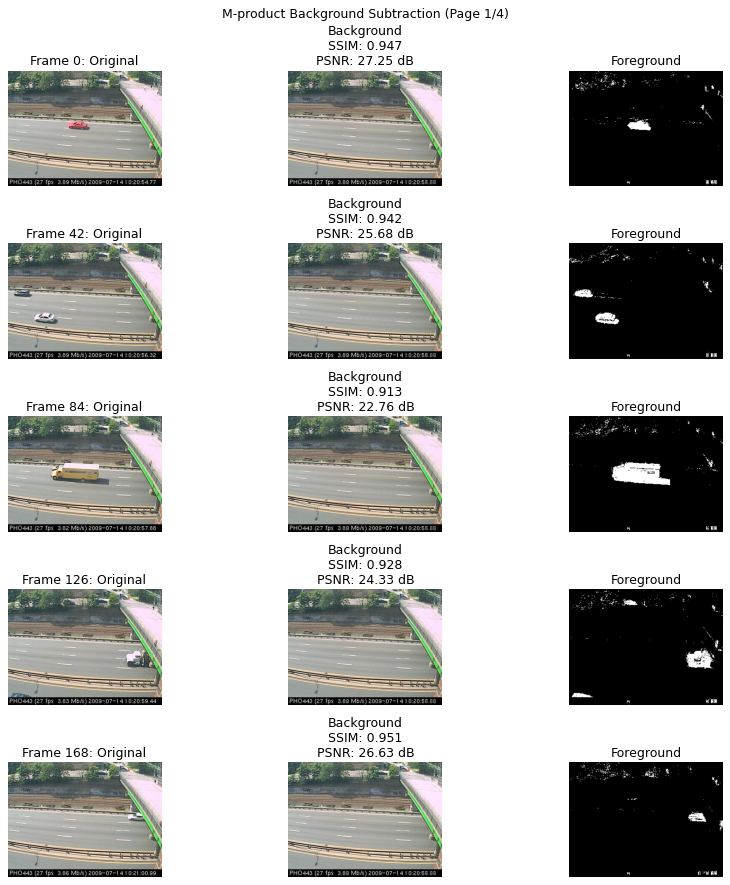

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0025476325994709].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.009824279137017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0115703621589134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.012910015468404].


Saving figure to Mprod2.png


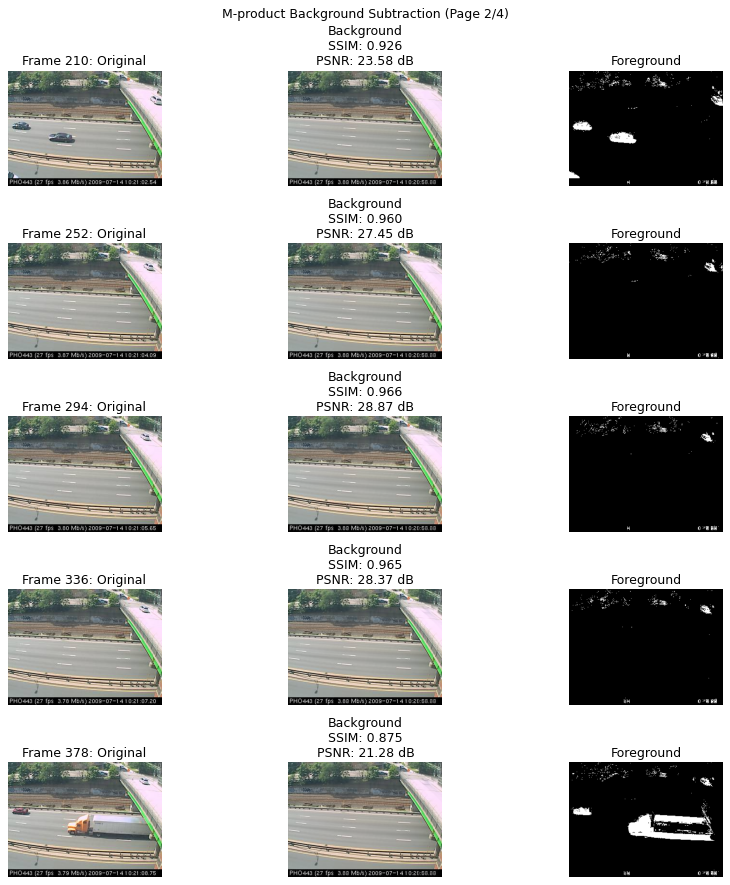

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0075564993001984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0015587945339508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0189334196517934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0084664363652611].


Saving figure to Mprod3.png


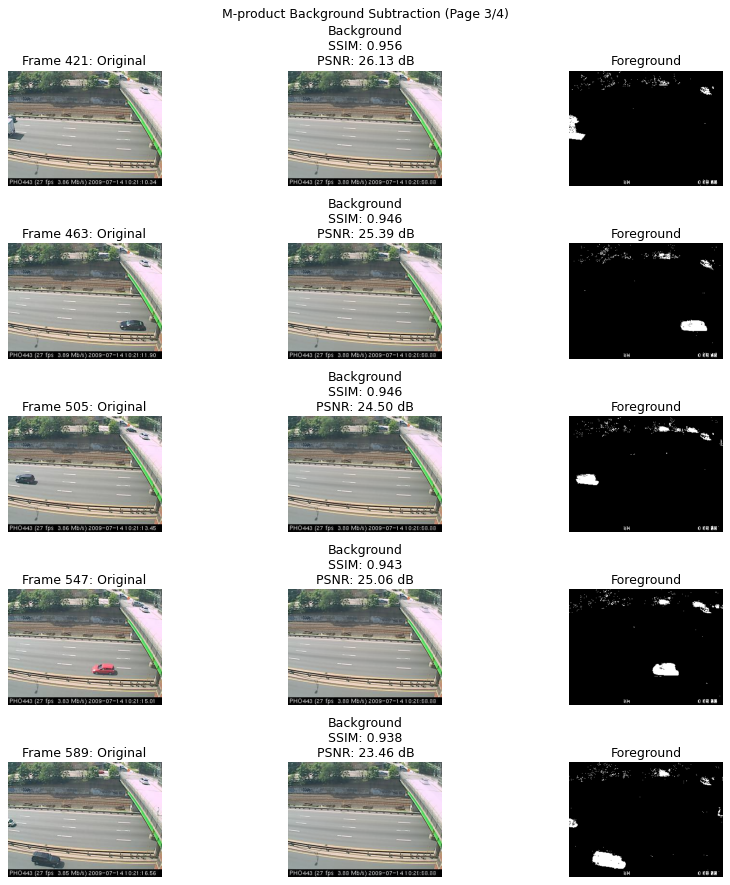

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0074881207882034].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0237588591686226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0371454285250836].


Saving figure to Mprod4.png


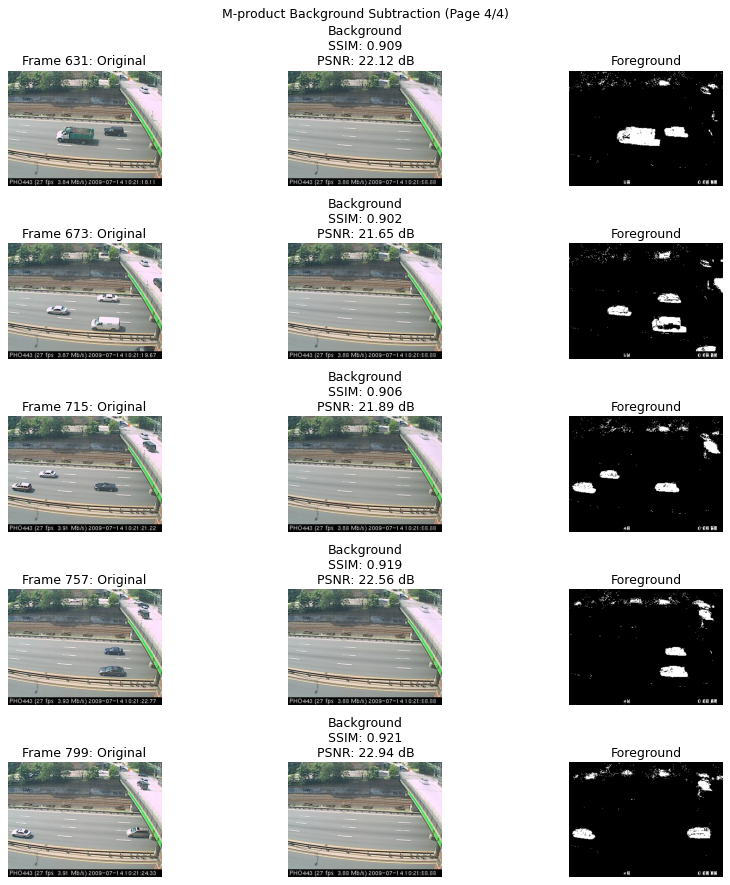

Too many frames (800) to display all. Selecting metrics for a sample...


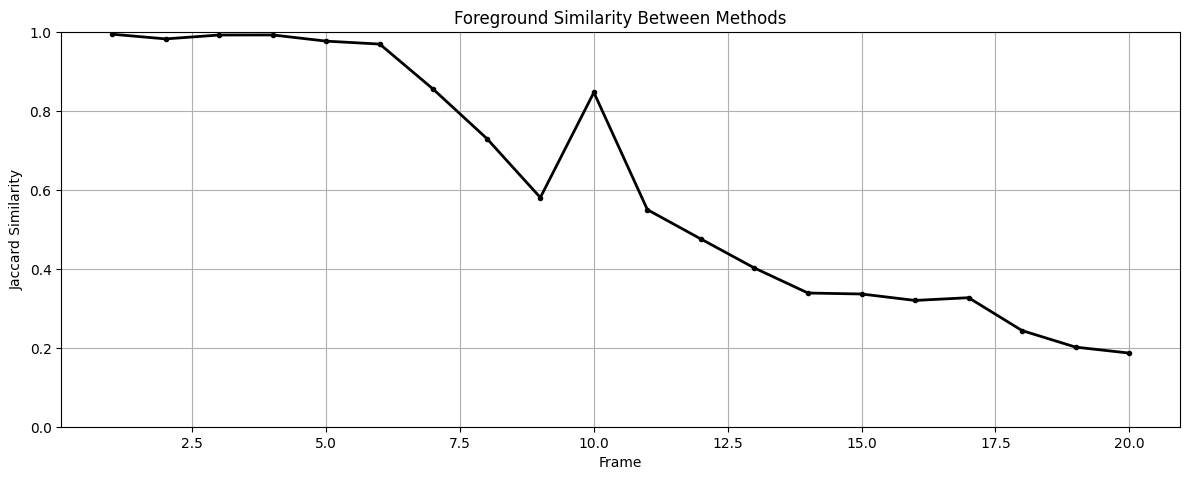


Comparison Metrics:
Average T-product model rank: 1.00
Average M-product model rank: 1.00
Average foreground similarity: 0.6151


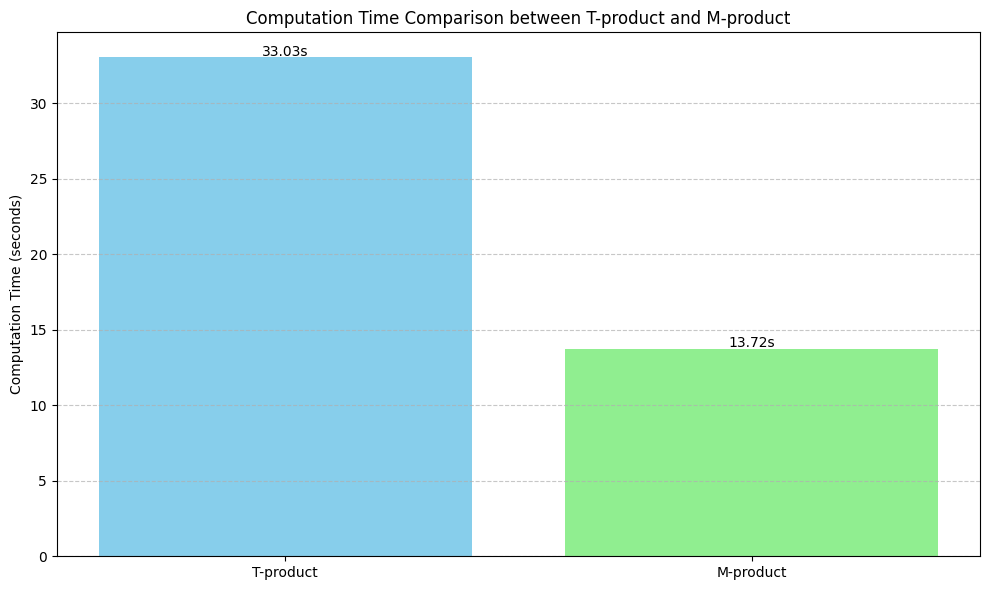

In [28]:
adaptive_tensor_svd_background()